https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
  
전력사용 요인 분석 및 모델링

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sklearn
from sklearn.linear_model import *
from sklearn.cluster import KMeans

from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv('./energy/train.csv', encoding="euc-kr")
test_df = pd.read_csv('./energy/test.csv', encoding="euc-kr")
sub = pd.read_csv('./energy/sample_submission.csv', encoding="euc-kr")

In [6]:
train_df.head(3)

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0


In [7]:
#칼럼 명을 바꿔주자 (ㄹㅇ 이게 낫겟다)
train_df.columns = ['num', 'datetime','target','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']

In [8]:
test_df.head(3)

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
test_df.columns = ['num','datetime','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']

In [12]:
train_df.head(1)

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0


In [14]:
test_df.head(1)

,num,datetime,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN


In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num              10080 non-null  int64  
 1   datetime         10080 non-null  object 
 2   temperature      3360 non-null   float64
 3   windspeed        3360 non-null   float64
 4   humidity         3360 non-null   float64
 5   precipitation    1680 non-null   float64
 6   insolation       3360 non-null   float64
 7   nelec_cool_flag  2296 non-null   float64
 8   solar_flag       1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


# Exploratory Data Analysys

In [16]:
eda_df = train_df.copy() #얕은복사 , 포인터같이 위치만 복사한다

In [17]:
eda_df['datetime'] = pd.to_datetime(eda_df['datetime'])

In [18]:
eda_df['datetime']

0        2020-06-01 00:00:00
1        2020-06-01 01:00:00
2        2020-06-01 02:00:00
3        2020-06-01 03:00:00
4        2020-06-01 04:00:00
                 ...        
122395   2020-08-24 19:00:00
122396   2020-08-24 20:00:00
122397   2020-08-24 21:00:00
122398   2020-08-24 22:00:00
122399   2020-08-24 23:00:00
Name: datetime, Length: 122400, dtype: datetime64[ns]

datetime 객체가 있으면 dt.hour , weekday date등으로 조사놓을 수 있따.

In [19]:
eda_df['hour'] = eda_df['datetime'].dt.hour 
eda_df['weekday'] = eda_df['datetime'].dt.weekday
eda_df['date'] = eda_df['datetime'].dt.date
eda_df['day'] = eda_df['datetime'].dt.day
eda_df['month'] = eda_df['datetime'].dt.month
eda_df['weekend'] = eda_df['weekday'].isin([5,6]).astype(int)

Monday=0, Sunday=6 이므로 토욜 일욜을 int형으로 바꿔서 week end로 변환시켜주자  

전력사용량은 사람의 행위에 의해 결정됩니다. 결국 전력을 사용하는 건 사람이기 때문입니다. 중요한 것은, 사람들이 어떤 요인으로 전력을 사용하는가 입니다. 대회에서 주어진 데이터를 기준으로, 크게 두 가지 요인을 생각해볼 수 있습니다.

- 시간 요인  
오전 8시가 되어 사람들이 사무실로 출근하면 냉방을 위해 에어컨을 틀고, 오후 9시가 되어 주점이 오픈을 하면 다양한 전력 소모가 발생합니다. 주말이 되면 자연스레 사무실 전력사용량은 줄고, 카페나 식당 전력사용량은 증가합니다. 이 때, 사람들의 행위의 중요한 기준이 되는 변수가 시간(hour, weekday)입니다.

- 기상 요인  
기상 또한 사람들의 행위에 중요한 영향을 미칩니다. 날씨가 덥고 불쾌지수가 높으면 에어컨을 켜고, 비가 오고 바람이 세게 불면 집 밖으로 잘 나가지 않는 등, 기상은 사람의 행위에 영향을 줌으로써 전력사용량에도 영향을 주게 됩니다.

위 두 가지 기준 시간적 요인,기상적 요인 을 중심으로 분석을 진행하겠습니다.

# 2.1 Energy Distribution

<AxesSubplot:xlabel='target', ylabel='Count'>

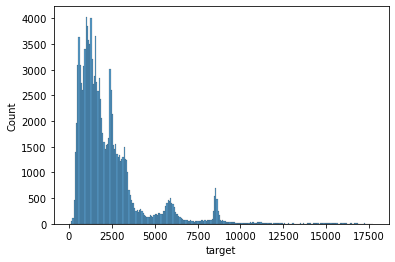

In [21]:
sns.histplot(eda_df.target) #전력사용량의 seaborn

<AxesSubplot:xlabel='target', ylabel='Count'>

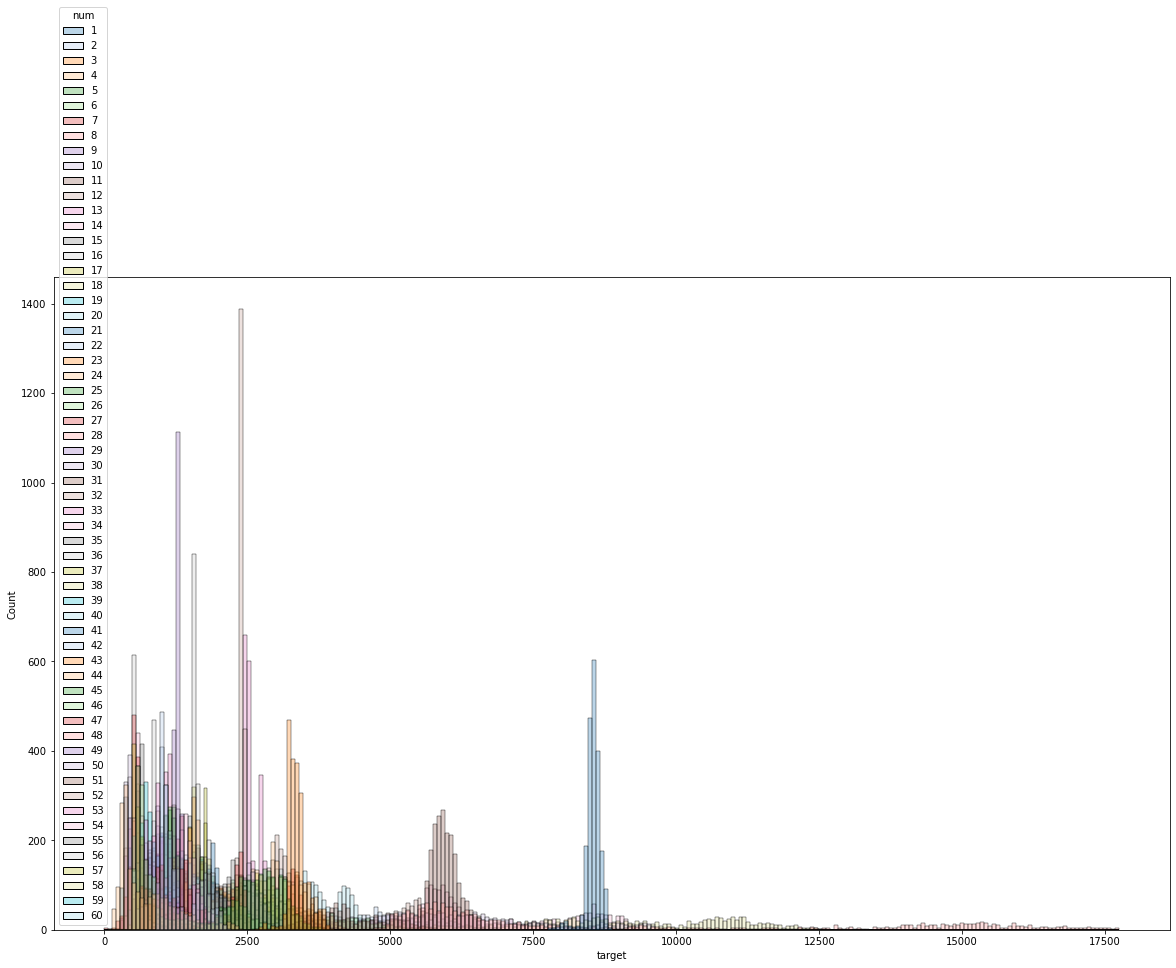

In [22]:
fig = plt.figure(figsize = (20, 12)) #20인찌 12인찌
sns.histplot(data=eda_df, x='target', hue='num', alpha=0.3, palette='tab20')

이게 핵심이다. 60개 건물들이 각자 전력사용량이 다름을 확인 할 수 있었다.  
  
블로그 주인은, location, scale 측면에서 건물마다 분포가 다르다 한다  
location은 위치일꺼고, scale은 뭘 말하는걸까?  
  
건물 번호를 원-핫으로 처리하는 방법을 생각했다 한다  

# 2.2 Energy usage of each building in relation to datetime

datetime 관련 변수  시간 / 요일 / 전체 timeline 에 따라 건물별로 전력 사용량 패턴을 본다  

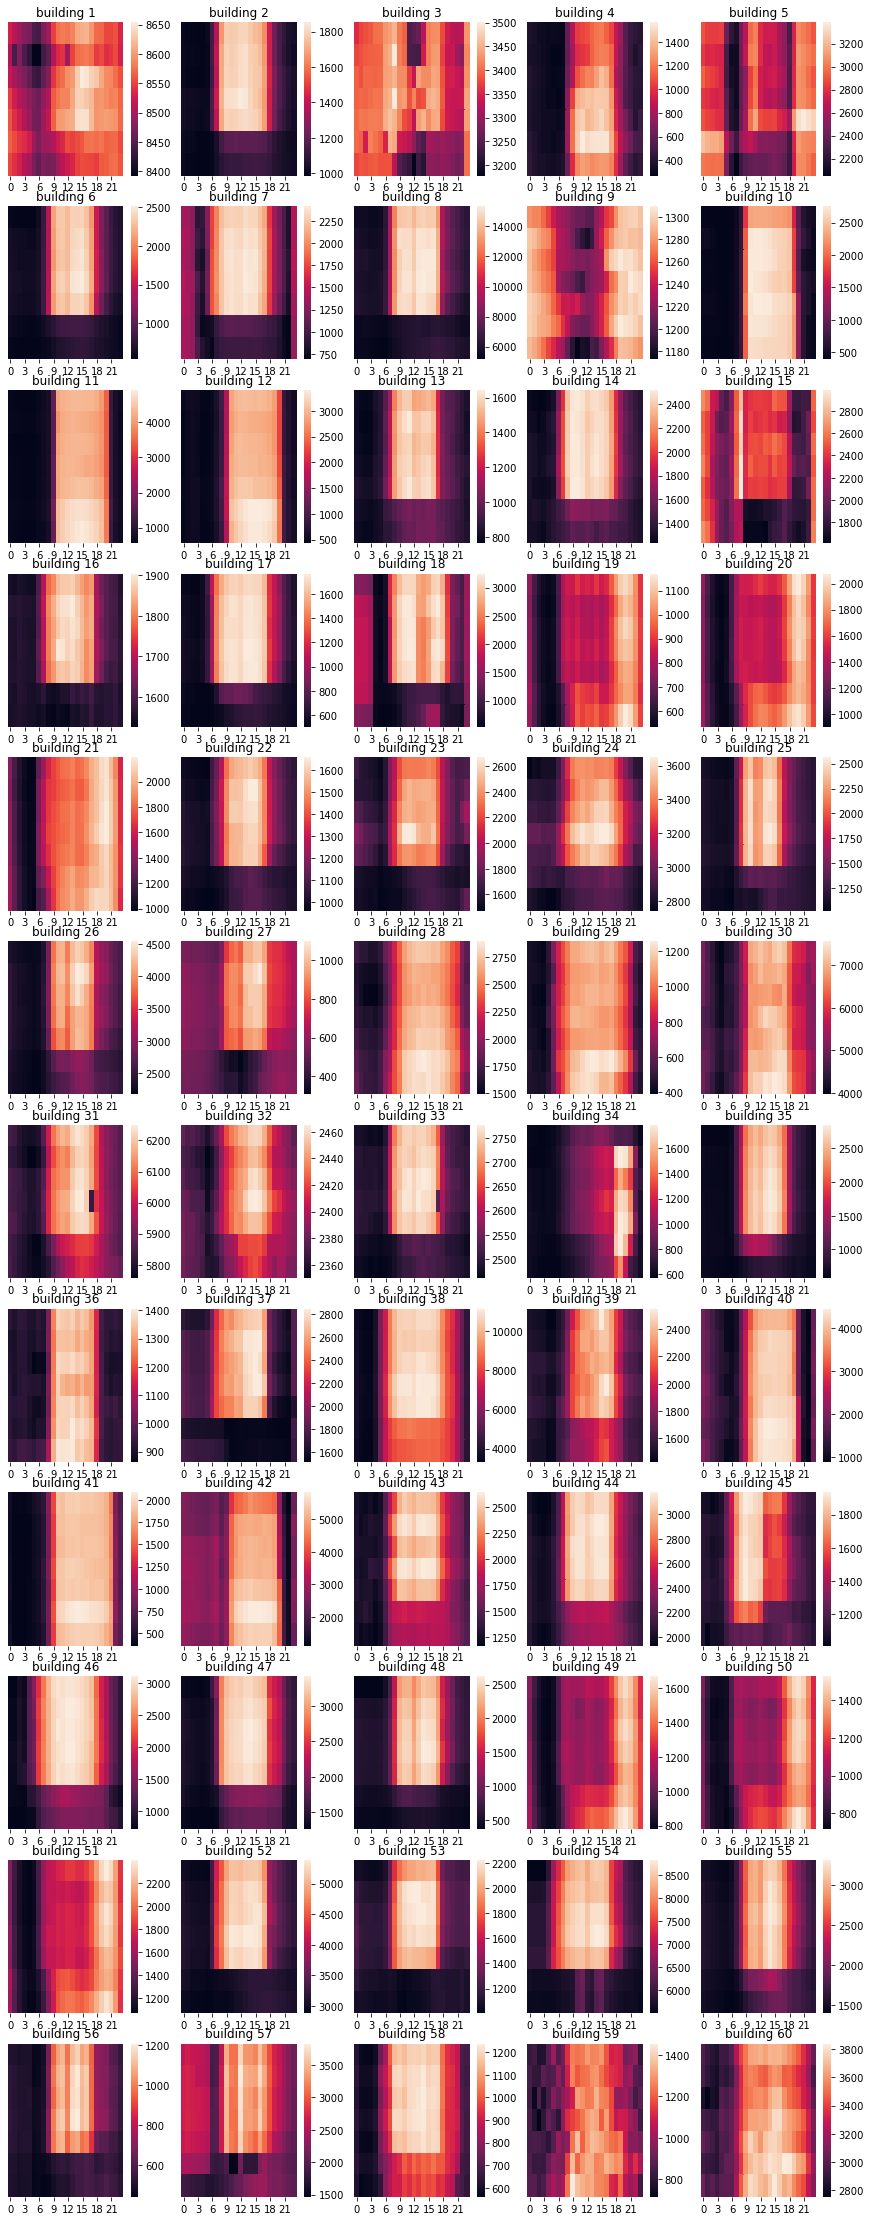

In [23]:
#각 건물의 전력사용량 / 주말 , 시간 
fig = plt.figure(figsize=(15, 40))
for num in eda_df['num'].unique():
    df = eda_df[eda_df.num == num]
    df = df.groupby(['weekday','hour'])['target'].mean().reset_index().pivot('weekday','hour','target')
    plt.subplot(12, 5, num)
    sns.heatmap(df)
    plt.title(f'building {num}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

Q. df = df.groupby(['weekday','hour'])['target'].mean().reset_index().pivot('weekday','hour','target') 는 무엇인가?  
  
Q. 위 히트맵은 어떻게 보는것이며 무엇을 표현한 것인가?  
  
Q. 저자는
- 평일 낮에만 전력사용량이 높은 건물
- 평일 주말 상관없이 낮에만 전력사용량이 높은 건물
  
건물 31, 33의 경우, 목요일 오후 5시에 공통적으로 전력사용량이 매우 낮게 나타난다 한다.  
  
좀 이런 느낌인 것 같다.  
   
이상한것부터 조진다.  

건물 31,33에서 목요일 오후 5시에 전력수요 이상치를 확인했다 한다.
  
# 오 진짜 그러네??



단순한 이상치인지, 매주 목요일마다 나타나는 패턴인지 확인

subplot 211 == 2,1,1 nrows, ncols, index

<AxesSubplot:xlabel='datetime', ylabel='target'>

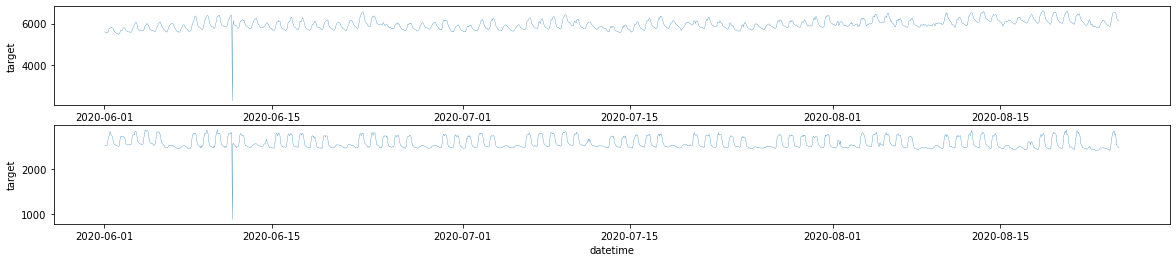

In [24]:
num_31 = eda_df[eda_df.num == 31]
num_33 = eda_df[eda_df.num == 33]

fig = plt.figure(figsize = (20, 4))
plt.subplot(211)
sns.lineplot(data = num_31, x = 'datetime', y = 'target', linewidth=0.3)
plt.subplot(212)
sns.lineplot(data = num_33, x = 'datetime', y = 'target', linewidth=0.3)

누가봐도 선 하나가보인다. 이상치다

In [25]:
print(num_31.loc[num_31.target < 4000, 'datetime'])
print(num_33.loc[num_33.target < 2000, 'datetime'])

61457   2020-06-11 17:00:00
Name: datetime, dtype: datetime64[ns]
65537   2020-06-11 17:00:00
Name: datetime, dtype: datetime64[ns]


직접 잡아준다

31번과 33번 건물에서 발생한 outlier가 정확히 같은 시간대에서 발생,  
지리적이거나 뭔가 요인이 있겠지?  

우선은 저 값은 이상치이므로. 주변값의 평균으로 이상치를 채운다 (보간)  

### Clustering building based on median energy usage of each hr and weekday

아까 히트맵을 통해서 건물별로 전력사용 양상을 보았다.   
비슷한 전력사용 양상을 보이는 애들끼리 군집화해본다  

In [26]:
#건물을 기준으로 하는 data frame 생성
by_weekday = eda_df.groupby(['num', 'weekday'])['target'].median().reset_index().pivot('num','weekday','target').reset_index()
by_hour = eda_df.groupby(['num', 'hour'])['target'].median().reset_index().pivot('num','hour','target').reset_index().drop('num', axis=1)

df = pd.concat([by_weekday, by_hour], axis=1)

In [29]:
by_weekday.head(5)

weekday,num,0,1,2,3,4,5,6
0,1,8565.588000,8552.628,8567.208,8574.336,8562.996000,8535.780,8521.524
1,2,1261.008000,1304.100,1303.776,1318.356,1300.050000,1074.546,1056.726
2,3,3369.363177,3351.834,3381.480,3382.668,3374.500282,3260.736,3250.800
3,4,538.488000,547.992,554.256,582.984,612.360000,602.640,608.256
4,5,2761.992000,2732.184,2730.240,2650.752,2880.792000,2747.736,2585.952


In [31]:
by_hour.head(3)

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,8546.472,8526.384,8515.368,8505.000,8498.520,8458.344,8458.344,8480.376,8501.112,8541.936,...,8600.256,8607.384,8606.088,8598.960,8576.280,8586.000,8573.688,8577.576,8577.576,8558.784
1,1008.288,1001.160,993.708,987.876,983.988,991.440,1111.644,1318.356,1612.872,1711.368,...,1707.480,1697.112,1693.224,1622.268,1367.280,1204.956,1124.604,1078.920,1039.068,1021.248
2,3274.884,3272.400,3262.896,3276.288,3291.300,3293.244,3320.784,3341.196,3363.120,3373.380,...,3388.338,3385.152,3406.212,3394.872,3334.176,3295.512,3290.760,3283.524,3283.740,3327.588


In [30]:
df.head(5)

,num,0,1,2,3,4,5,6,0,1,...,14,15,16,17,18,19,20,21,22,23
0,1,8565.588000,8552.628,8567.208,8574.336,8562.996000,8535.780,8521.524,8546.472,8526.384,...,8600.256,8607.384,8606.088,8598.960,8576.280,8586.000,8573.688,8577.576,8577.576,8558.784
1,2,1261.008000,1304.100,1303.776,1318.356,1300.050000,1074.546,1056.726,1008.288,1001.160,...,1707.480,1697.112,1693.224,1622.268,1367.280,1204.956,1124.604,1078.920,1039.068,1021.248
2,3,3369.363177,3351.834,3381.480,3382.668,3374.500282,3260.736,3250.800,3274.884,3272.400,...,3388.338,3385.152,3406.212,3394.872,3334.176,3295.512,3290.760,3283.524,3283.740,3327.588
3,4,538.488000,547.992,554.256,582.984,612.360000,602.640,608.256,372.816,355.104,...,1294.704,1288.224,1236.384,1121.472,917.568,748.224,566.352,479.520,405.216,422.496
4,5,2761.992000,2732.184,2730.240,2650.752,2880.792000,2747.736,2585.952,2999.808,2920.320,...,2630.880,2667.600,2584.224,2552.256,2344.896,2788.992,3132.000,3111.696,3091.824,3013.200


In [32]:
columns = ['num'] + ['day' + str(i) for i in range(7)] + ['hour' + str(i) for i in range(24)]
df.columns = columns

In [33]:
df.head(3)

,num,day0,day1,day2,day3,day4,day5,day6,hour0,hour1,...,hour14,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22,hour23
0,1,8565.588000,8552.628,8567.208,8574.336,8562.996000,8535.780,8521.524,8546.472,8526.384,...,8600.256,8607.384,8606.088,8598.960,8576.280,8586.000,8573.688,8577.576,8577.576,8558.784
1,2,1261.008000,1304.100,1303.776,1318.356,1300.050000,1074.546,1056.726,1008.288,1001.160,...,1707.480,1697.112,1693.224,1622.268,1367.280,1204.956,1124.604,1078.920,1039.068,1021.248
2,3,3369.363177,3351.834,3381.480,3382.668,3374.500282,3260.736,3250.800,3274.884,3272.400,...,3388.338,3385.152,3406.212,3394.872,3334.176,3295.512,3290.760,3283.524,3283.740,3327.588


In [34]:
#'전력사용량' 이 아니라, 
#'요일 & 시간대'에 따른 전력 사용량의 경향성에 따라서만 군집화 할 것이므로, 특수한 scaling이 필요하다.
#standard scaling
for i in range(len(df)):
    df.iloc[i, 1:8] = (df.iloc[i, 1:8] - df.iloc[i, 1:8].mean()) / df.iloc[i, 1:8].std() #요일 별 전력 중앙값에 대해 scaling
    df.iloc[i, 8:] = (df.iloc[i, 8:] - df.iloc[i, 8:].mean()) / df.iloc[i, 8:].std()     #시간대별 전력 중앙값에 대해 scaling

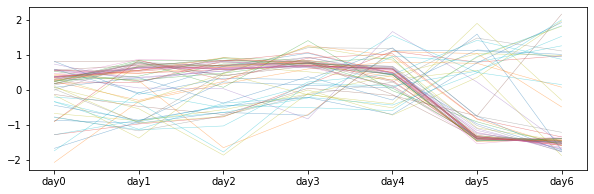

In [35]:
#시각화를 해봅시다
fig = plt.figure(figsize = (10, 3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 1:8], alpha = 0.5 , linewidth = 0.5)

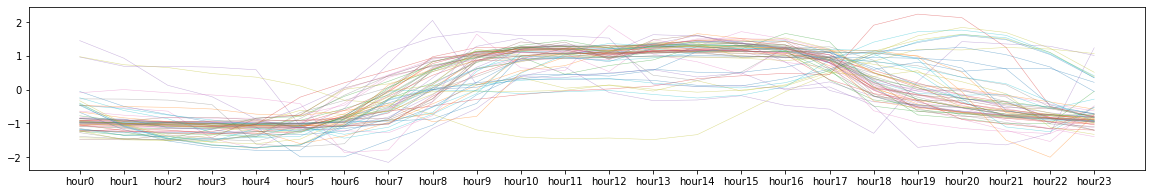

In [36]:
fig = plt.figure(figsize = (20, 3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 8:], alpha = 0.5 , linewidth = 0.5)

건물별 요일 / 시간 에 따라 전력사용량의 경향이 확실히 보인다.

# k-means clustering

In [44]:
# elbow method를 통해 군집의 개수 결정??? 
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters = n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
    
    plt.figure(1, figsize = (12, 6))
    plt.plot(n_clusters, sum_of_squared_distance, 'o')
    plt.plot(n_clusters, sum_of_squared_distance, '-', alpha=0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

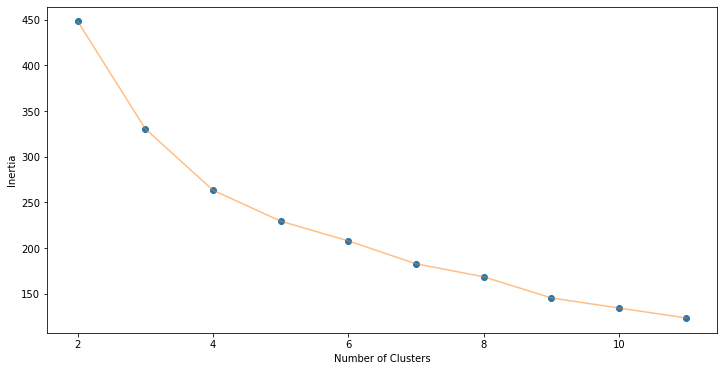

In [45]:
change_n_clusters([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])

뭘 보고 최적의 군집수로 4를 골랐단거지?

In [46]:
kmeans = KMeans(n_clusters=4, random_state=2)
km_cluster = kmeans.fit_predict(df.iloc[:, 1:])

In [47]:
df_clust = df.copy()
df_clust['km_cluster'] = km_cluster

In [48]:
# visualizing result of kmeans clustering
n_c = len(np.unique(df_clust.km_cluster)) 

뭔진 모르겠는데, K값을 4로 정하고, 군집화를 한 결과를 km_cluster로 집어넣었다.  
그리고 클러스터된 애들중에 한 값만? 나오게??   
(그니까 특정 유형으로 몰릴 것 아닌가? [11111] [22222] [33333] 일케 있으면 1,2,3만 뽑히게 )  



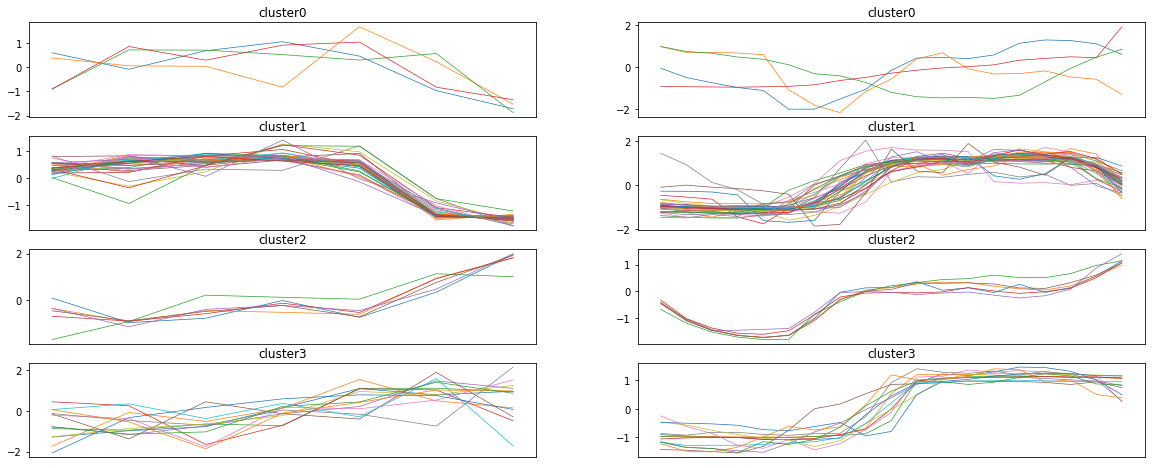

In [51]:
fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = df_clust[df_clust.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

cluster 0 의 그림이 다르다??

In [52]:
eda_df = eda_df.merge(df_clust[['num', 'km_cluster']], on = 'num', how = 'left')

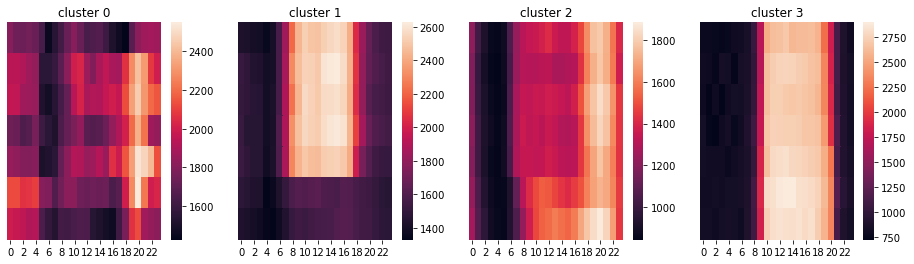

In [55]:
fig = plt.figure(figsize = (20, 4))
for c in range(4):
    temp = eda_df[eda_df.km_cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['target'].median().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(1, 5, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

어느 정도 비슷한 전력 사용 양상을 보이는 건물끼리 군집화 된 것으로 보입니다. 요약해보자면,

- cluster 0 : 야간과 주간 전력소모 차이는 뚜렷하지만, 평일 주말 관계없이 전력소모가 일정하거나 주말 전력소요가 조금 더 높은 건물(식당, 상점, 카페)
- cluster 1 : 출근 전 시간대에 전력소모가 매우 낮고, 저녁이 될 수록 전력소모가 커짐(산업시설?)
- cluster 2 : 평일보다 주말에 전력소모가 크고, 낮보다 밤에 전력소모가 큰 건물(유흥시설, 주점)
- cluster 3 : 평일 주간에 전력소모가 크고, 평일야간이나 주말에는 전력소모가 작은 건물(사무실, 학교)

건물의 유형이 이렇게 딱 나오는구나!

In [61]:
# dictionary mapping cluster and building
match = df_clust[['num', 'km_cluster']]
clust_to_num = {0:[], 1:[], 2:[], 3:[]} #와 씨 이런건 또 첨보네 인덱스에 따라서 새로운 배열을 초기화하는 딕셔너리네
for i in range(60):
    c = match.iloc[i, 1]
    clust_to_num[c].append(i + 1)

# Cluster Analysis

군집별로 건물들을 나누고 시각화 함으로써, 각 군집 별 건물 전력소요에 대한 인사이트를 얻어보자!

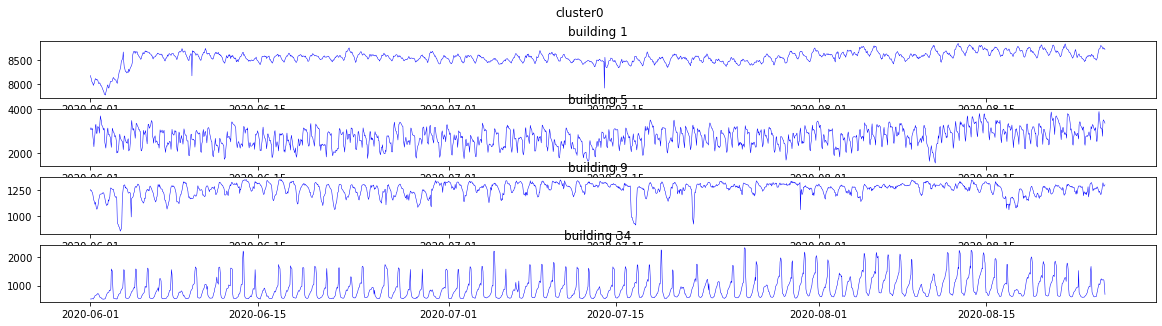

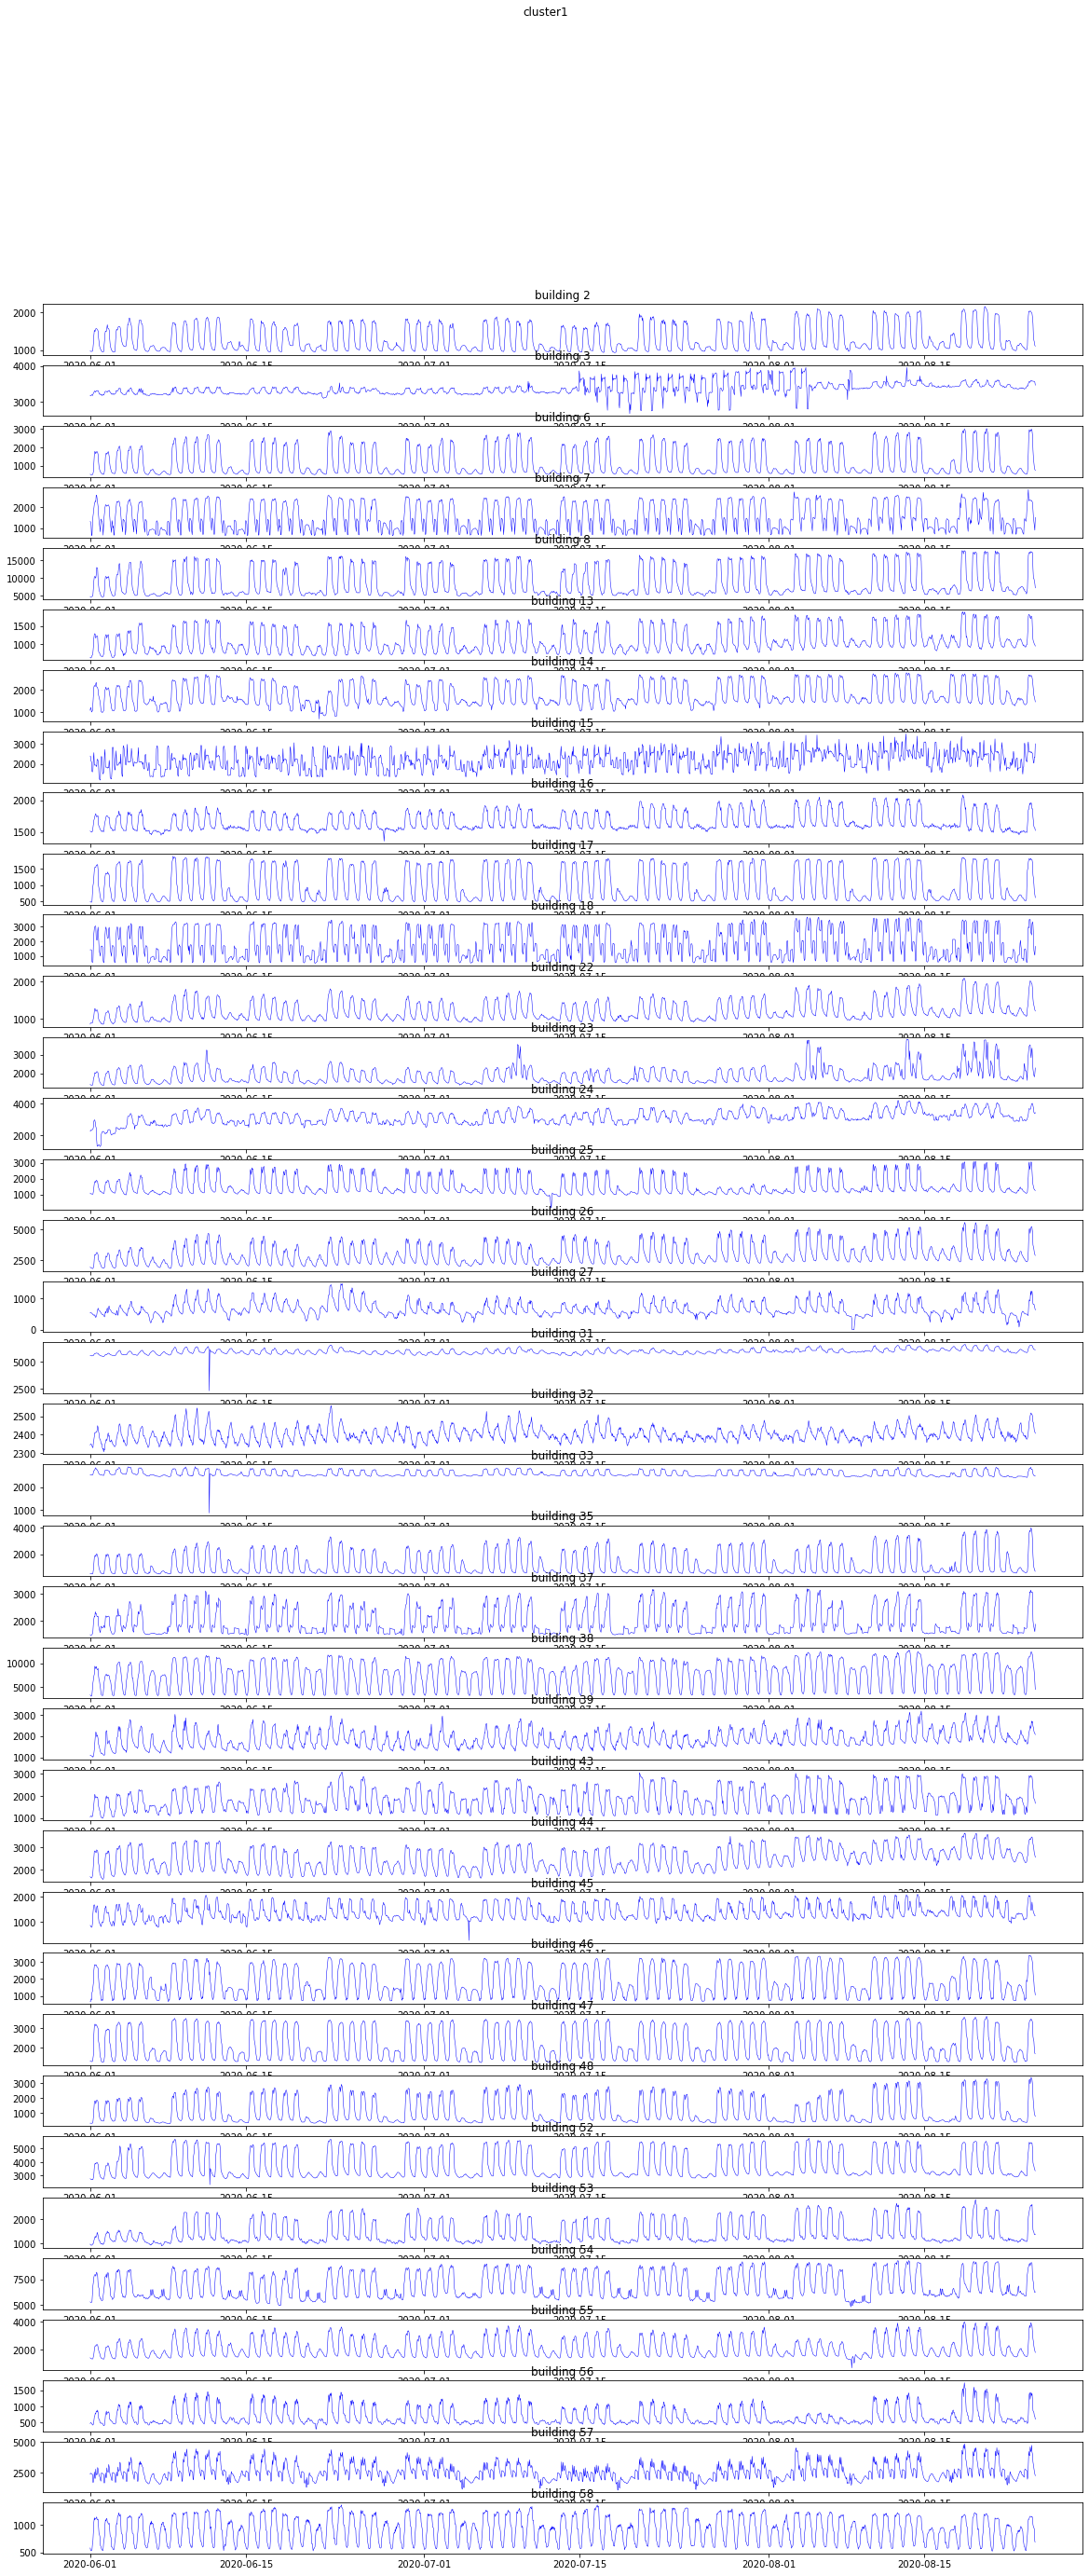

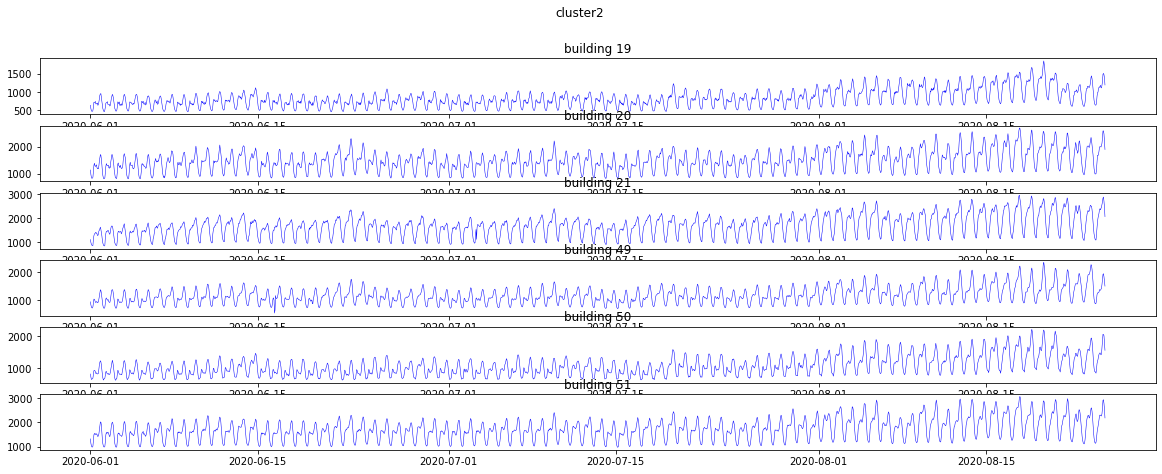

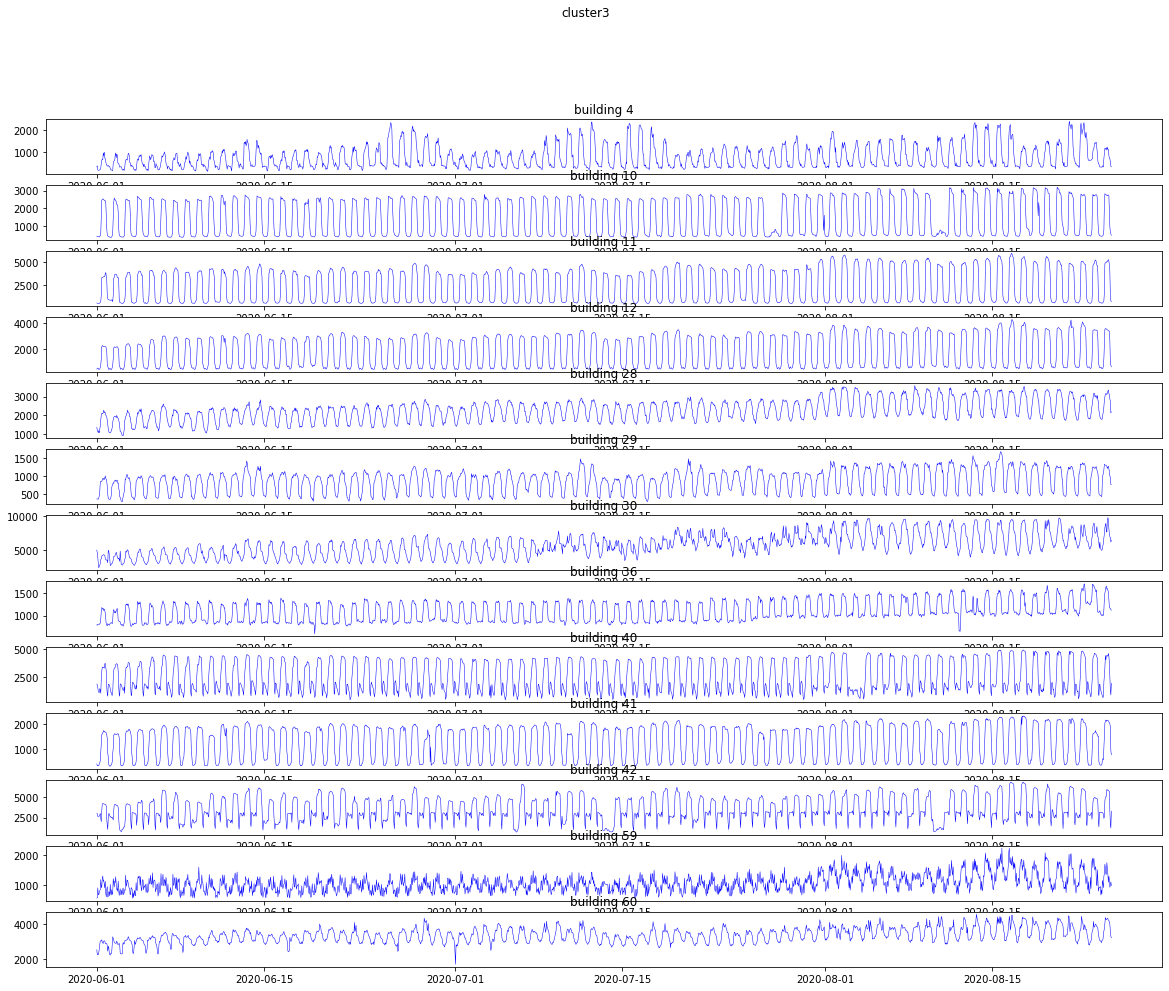

In [64]:
for c in range(4):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (20, 1.2 * n_nums))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        plt.subplot(n_nums, 1, i + 1)
        sns.lineplot(data = temp_2, x='datetime', y = 'target', linewidth = 0.5, color = 'blue')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')

이제 이상치들이 좀 보인다, 1, 문제의 31, 33 ,그리고 45 , 30 

우선, lineplot을 통해, 요일과 시간보다는 날짜에 초점을 맞추어 분석해보겠습니다.  
  
- cluster 0 : 낮과 밤에 따라서 전력사용량이 증가 감소를 반복하는 경향성이 보입니다.  
건물 4의 경우, 불분명한 원인으로 인해 특정 주기에 낮 전력 소요가 높아지는 현상이 보입니다.  
많은 건물들에서 시간이 지남에 따라 전력소요가 증가하는 양상을 보입니다.(냉방으로 인한 것으로 보입니다.)  
  
- cluster 1 : 한 군집으로 분류되긴 했으나, 공통적인 특징이 보이지 않습니다.  
건물 1의 경우, 초반 3일동안 전력소요가 낮게 나타납니다.  
  
- cluster 2 : 공통적으로 더위가 심해질수록 전력사용량이 점진적으로 증가합니다.  
- cluster 3 : 평일과 주말이 구분되는 양상을 보입니다. 이 군집에 속한 건물들은 공통적으로 대체공휴일(8.17)에도 전력소요가 낮게 나타납니다. 사무실과 학교 같은 일터 라는 추측에 확신을 가질 수 있습니다.  
건물 3의 경우, 7.15-8.4 일동안 비정상적인 전력소요 양상이 보입니다.  
건물 23의 경우, 8.4일부터 전력소요의 양상이 바뀝니다.  
이 군집에 속한 대부분의 건물들에서, 점심시간(11-12시)에 전력소요가 소폭 감소하는 모습도 보입니다.  


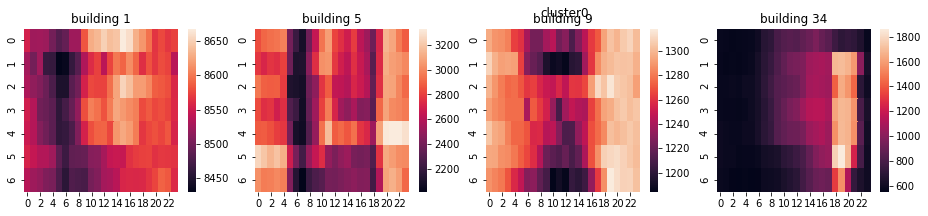

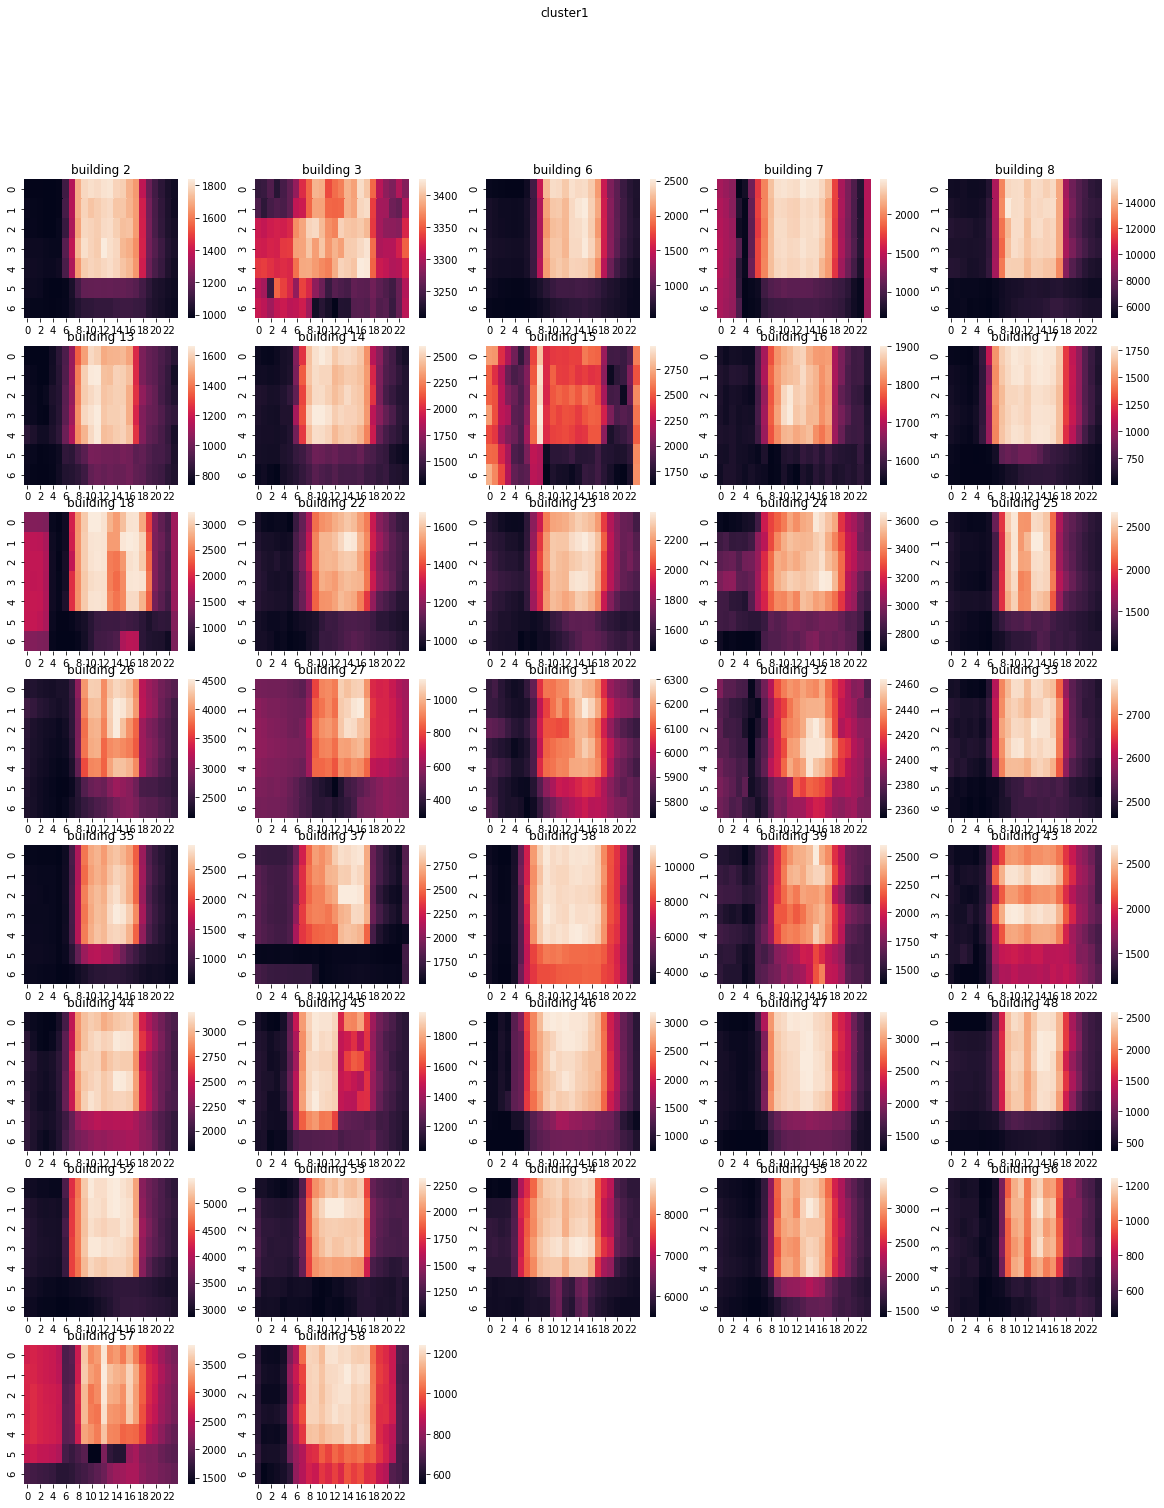

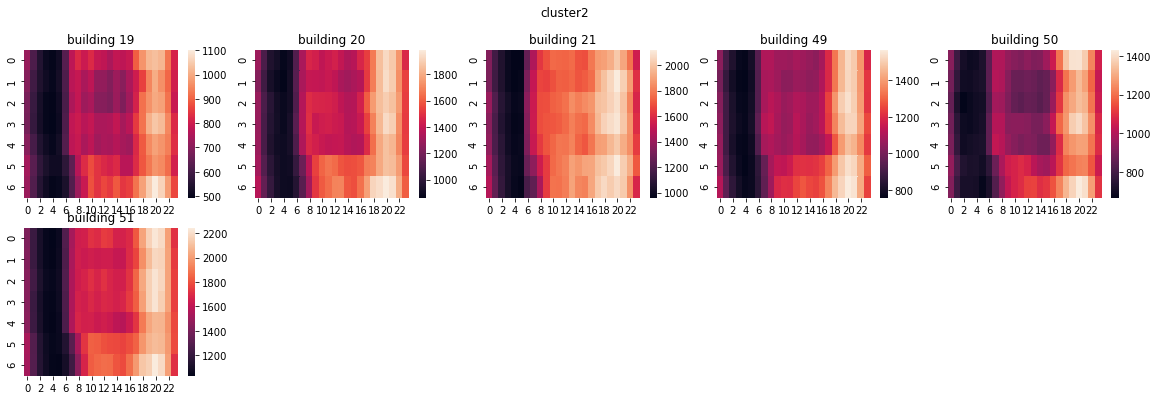

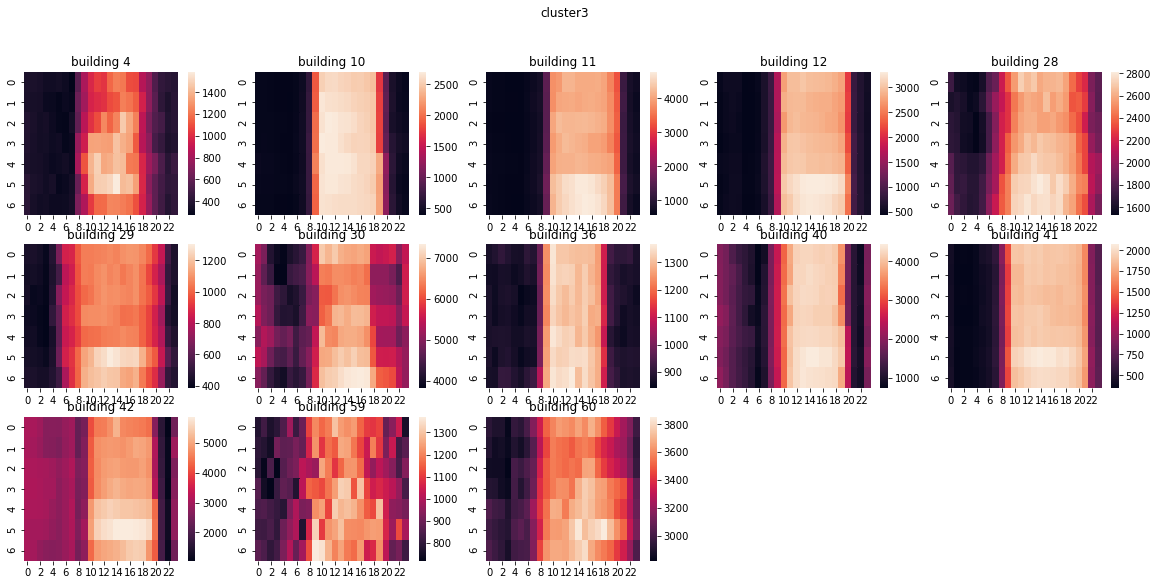

In [65]:
#heatmap ( energy usage of each building ~ cluster , weekday , hour)
for c in range(4):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (20, 3*(n_nums//5 + 1)))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        temp_2 = temp_2.groupby(['weekday', 'hour'])['target'].median().reset_index().pivot('weekday','hour','target')
        plt.subplot(n_nums//5 +1 , 5 , i+1)
        sns.heatmap(temp_2)
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')